# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='/home/adebraine/Documents/Personal Projects/RL - Udacity/deep-reinforcement-learning/p2_continuous-control/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# from ddpg_agent import Agent
import time
plt.ion()

In [9]:
# Watch changes and reload automatically
%load_ext autoreload
%autoreload 2

from ddpg_agent import Agent
seed = 0

hidden_layers = {'actor':[256,128],'critic':[256,128,128]}
# Create agent
agent = Agent(state_size=state_size, action_size=action_size, hidden_layers=hidden_layers, n_agents=num_agents, random_seed=seed)

In [7]:
def ddpg(n_episodes=2000, max_t = 1000, window_size=100, score_threshold=30.0, 
         print_interval=10, epochs=1000):

    scores_deque = deque(maxlen=window_size) 
    scores = []        
    best_average_score = -np.inf
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Training on {} started...".format(device))
    
    for i_episode in range(1, epochs+1):
        
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        
        agent.reset()
        episode_scores = np.zeros(num_agents) 

        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done

            agent.step(states=states, actions=actions, rewards=rewards, next_states=next_states, dones=dones)
            episode_scores += np.array(rewards)
            states = next_states
            if np.any(dones):
                break

        episode_score = np.mean(episode_scores) # Summary of scores for this episode
        scores_deque.append(episode_score)
        scores.append(episode_score)
        average_score = np.mean(scores_deque)

        print('\rEpisode: {}\tAverage Score: {:.2f}\tCurrent Score: {:.2f}'.format(i_episode, average_score, episode_score), end="")
        if i_episode % print_interval == 0:
            print('\rEpisode: {}\tAverage Score: {:.2f}\tCurrent Score: {:.2f}'.format(i_episode, average_score, episode_score))

        if average_score >= score_threshold:
            print('\nEnvironment solved in {} episodes!\tAverage Score: {:.2f}'.format(i_episode-window_size, average_score))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break

    np.save('scores.npy', scores)
    return scores

In [8]:
scores = ddpg()

Training on cuda:0 started...
Episode: 10	Average Score: 1.12	Current Score: 1.45
Episode: 20	Average Score: 2.16	Current Score: 3.89
Episode: 30	Average Score: 3.07	Current Score: 5.31
Episode: 40	Average Score: 3.80	Current Score: 6.60
Episode: 50	Average Score: 4.48	Current Score: 8.16
Episode: 60	Average Score: 5.15	Current Score: 9.29
Episode: 70	Average Score: 5.71	Current Score: 8.502
Episode: 80	Average Score: 6.09	Current Score: 9.91
Episode: 90	Average Score: 6.46	Current Score: 9.730
Episode: 100	Average Score: 6.80	Current Score: 10.15
Episode: 110	Average Score: 7.70	Current Score: 9.989
Episode: 120	Average Score: 8.44	Current Score: 11.59
Episode: 130	Average Score: 9.01	Current Score: 10.75
Episode: 140	Average Score: 9.45	Current Score: 10.16
Episode: 150	Average Score: 9.86	Current Score: 13.86
Episode: 160	Average Score: 10.43	Current Score: 17.56
Episode: 170	Average Score: 11.31	Current Score: 19.52
Episode: 180	Average Score: 12.47	Current Score: 20.49
Episode: 19

In [20]:
scores = np.load('scores.npy')
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_scores(scores, order):
    plt.plot(np.arange(len(scores)), scores)
    sns.regplot(x=np.arange(len(scores)), y=scores, order=order, scatter=False)
    plt.xlabel('Number of Episodes')
    plt.ylabel('Score')
    plt.savefig('scores.png')
    plt.show()

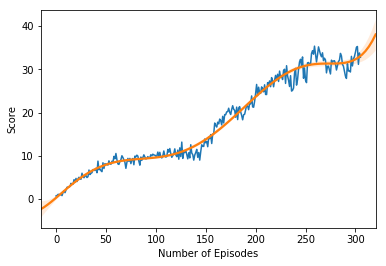

In [21]:
plot_scores(scores, order=6)

In [10]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))

In [11]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = agent.act(states)
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 33.46949925189838


In [17]:
env.close()